This code explain implementation of DPRP 
we pass x raw data to dprp algorithm and produces differentially privacy dataset .
now we do prediction on original raw data and also on reconstructed x' 
we have analysed the accuracy on this two datasets by tuning some parameters .

Now to actually measure differential privacy , we have removed one entry and again reconstructed x' 
Finally analysed the  predictions on this two datasets . 

Also we have modified one entry and again analysed the results.

In [18]:
# Importing the necessary packages
import pandas as pd 
import sklearn
from sklearn.random_projection import GaussianRandomProjection
import numpy as np
from matplotlib import pyplot as plt
import math
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

convert to matrix from dataframe

In [19]:
data_raw = pd.read_csv('datasets/after_preproccessing.csv')
data_raw.drop(columns=data_raw.columns[0], axis=1,  inplace=True)
label_data = data_raw['is_patient']
label_data=label_data.replace(2,0)
data_raw.drop(columns=['is_patient'], axis=1 , inplace=True)
X_Matrix = data_raw.to_numpy()
data_raw.to_csv('datasets/train.csv')
labels = label_data.to_numpy()

Random Projections ( Gaussian RP )
Reducing dimensions from 11 components to n_components = 8 
Here hyperparameters : n_components (8 for now )
K1=8

Recommended parameters from paper:
delta : 0.0001        
epsilon : [8,6,4,2,1]            
Privacy budget :              
b=80% for Random Projection          
1-b% for SVD ( covariace )          
k1=8           
k2=0.6 *d                 

In [20]:
# Random data and its transformation
def DRPR(k1,Input_dataset,label_dataset,data_size):

    #Random Projection
    X_random = Input_dataset
    gauss_data = GaussianRandomProjection(random_state=0 , n_components=k1)
    X_transformed = gauss_data.fit_transform(X_random)

    # Get the size of the transformed data
    #print('Shape of transformed data is: ' + str(X_transformed.shape))
    Random_Projection_matrix=gauss_data.components_


    delta1=8e-5
    epsilon1=3.2
    std_p = 1/math.sqrt(k1)
    Z=5e-5

    std1=Z * std_p * math.sqrt(k1 + 2*math.sqrt(k1*math.log(2/delta1)) + 2*math.log(2/delta1) ) * math.sqrt(2* ( math.log(1/(2*delta1))  +epsilon1 ) ) /(epsilon1)

    M1= np.random.normal(0,pow(std1,2) , size=(data_size,k1))

    P_new = X_transformed + M1

    # for covariance and svd
    Xc=np.cov(X_Matrix.T)
    Z2=1e-3
    delta2 = 2e-5
    epsilon2 = 0.8
    var2 = pow(Z2,2) * math.sqrt( 2* math.log( 1.25 ) / delta2 ) / epsilon2

    t1 = np.random.normal(0 , var2 , size=(11,11) )
    M2 = (t1 + t1.T)/2

    XC_new = Xc + M2
    u , s , vt = np.linalg.svd(XC_new,full_matrices=True)
    k2 = int(0.6*11)
    n=u.shape[0]
    u_new=[]
    for i in range(n):
        u_new.append(u[i][:k2])
    u_k2 =np.array(u_new)


    #Finally 
    X_final = np.matmul (  np.matmul( P_new , np.linalg.pinv( np.matmul(u_k2.T, Random_Projection_matrix.T   ) )  )   ,u_k2.T )


    #with drpr prediction
    X_train, X_val, y_train, y_val = train_test_split(X_final, label_dataset , test_size=0.2, random_state=42)

    def fit_and_score_model(X, y, model_clf, X_v, y_v):
        model_clf.fit(X, y)
        return model_clf.score(X_v, y_v)
    rfc_clf = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42, max_depth=200,)
    accuracy_result=fit_and_score_model(X_train, y_train, rfc_clf, X_val, y_val)


    return accuracy_result
    


In [21]:
#without privacy prediction
X_train, X_val, y_train, y_val = train_test_split(X_Matrix, labels, test_size=0.2, random_state=42)

def fit_and_score_model(X, y, model_clf, X_v, y_v):
    model_clf.fit(X, y)
    return model_clf.score(X_v, y_v)
rfc_clf = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42, max_depth=200,)
accuracy_result=fit_and_score_model(X_train, y_train, rfc_clf, X_val, y_val)

In [22]:
print(accuracy_result)

0.7435897435897436


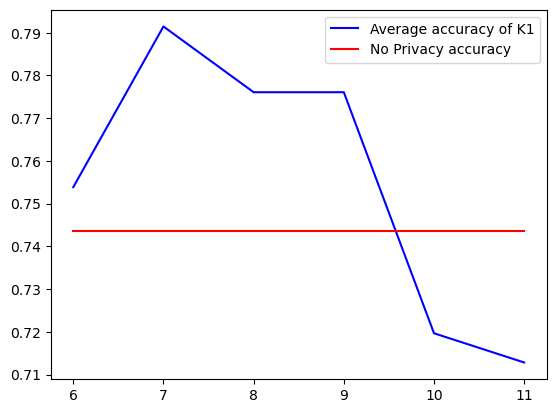

In [23]:
k1=[6,7,8,9,10,11]
Per_k_avg_accuracy=[]

for k in k1:
    k_avg=[]
    n_avg=[]
    for e in range(5):
        r= DRPR(k,X_Matrix,labels,583)
        k_avg.append(r)
        
    Per_k_avg_accuracy.append(mean(k_avg))
    
NO_privacy_accuracy=[accuracy_result]*len(k1)

plt.plot(k1,Per_k_avg_accuracy,'-b' , label='Average accuracy of K1')
plt.plot(k1,NO_privacy_accuracy ,'-r', label= 'No Privacy accuracy')
plt.legend()
plt.show()
        
    

In [32]:
print(Per_k_avg_accuracy)

[0.764102564102564, 0.7965811965811966, 0.7863247863247863, 0.770940170940171, 0.7316239316239316, 0.7230769230769231]


I have removed One entry from original data set and again generated New X_final :     
So Only one entry is less now 


In [24]:
data_raw = pd.read_csv('datasets/after_preproccessing2.csv')
data_raw.drop(columns=data_raw.columns[0], axis=1,  inplace=True)
label_data = data_raw['is_patient']
label_data=label_data.replace(2,0)
data_raw.drop(columns=['is_patient'], axis=1 , inplace=True)
X_Matrix = data_raw.to_numpy()
data_raw.to_csv('datasets/train.csv')
labels = label_data.to_numpy()

In [25]:
#without privacy prediction
X_train, X_val, y_train, y_val = train_test_split(X_Matrix, labels, test_size=0.2, random_state=42)

def fit_and_score_model(X, y, model_clf, X_v, y_v):
    model_clf.fit(X, y)
    return model_clf.score(X_v, y_v)
rfc_clf = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42, max_depth=200,)
accuracy_result=fit_and_score_model(X_train, y_train, rfc_clf, X_val, y_val)

In [26]:
print(accuracy_result)

0.7264957264957265


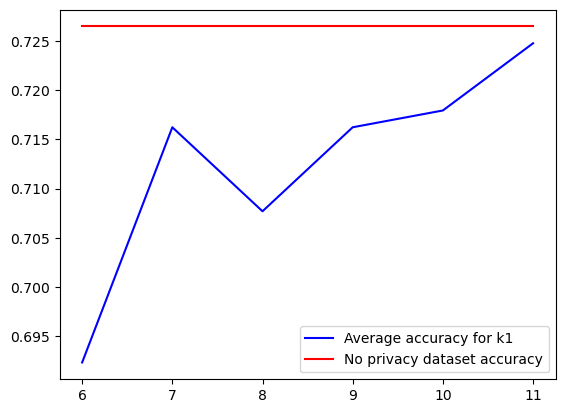

In [27]:
k1=[6,7,8,9,10,11]
Per_k_avg_accuracy=[]

for k in k1:
    k_avg=[]
    n_avg=[]
    for e in range(5):
        r= DRPR(k,X_Matrix,labels,582)
        k_avg.append(r)
        
    Per_k_avg_accuracy.append(mean(k_avg))
    
NO_privacy_accuracy=[accuracy_result]*len(k1)

plt.plot(k1,Per_k_avg_accuracy , '-b',label='Average accuracy for k1')
plt.plot(k1,NO_privacy_accuracy,'-r', label='No privacy dataset accuracy')
plt.legend()
plt.show()

We can see here now k = 10 , 11 is suitable .    
means random projection dimension reductio to 10 , 11 from 12 is favaroble.

After modification of one entry .
I have modified one row and again doing DPRP

In [34]:
data_raw = pd.read_csv('datasets/after_preproccessing3.csv')
data_raw.drop(columns=data_raw.columns[0], axis=1,  inplace=True)
label_data = data_raw['is_patient']
label_data=label_data.replace(2,0)
data_raw.drop(columns=['is_patient'], axis=1 , inplace=True)
X_Matrix = data_raw.to_numpy()
data_raw.to_csv('datasets/train3.csv')
labels = label_data.to_numpy()

In [35]:
#without privacy prediction
X_train, X_val, y_train, y_val = train_test_split(X_Matrix, labels, test_size=0.2, random_state=42)

def fit_and_score_model(X, y, model_clf, X_v, y_v):
    model_clf.fit(X, y)
    return model_clf.score(X_v, y_v)
rfc_clf = RandomForestClassifier(n_estimators=150, n_jobs=-1, random_state=42, max_depth=200,)
accuracy_result=fit_and_score_model(X_train, y_train, rfc_clf, X_val, y_val)

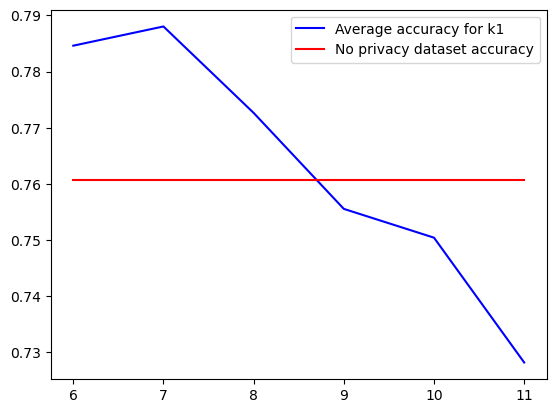

In [38]:
k1=[6,7,8,9,10,11]
Per_k_avg_accuracy=[]

for k in k1:
    k_avg=[]
    n_avg=[]
    for e in range(5):
        r= DRPR(k,X_Matrix,labels,583)
        k_avg.append(r)
        
    Per_k_avg_accuracy.append(mean(k_avg))
    
NO_privacy_accuracy=[accuracy_result]*len(k1)



plt.plot(k1,Per_k_avg_accuracy , '-b',label='Average accuracy for k1')
plt.plot(k1,NO_privacy_accuracy,'-r', label='No privacy dataset accuracy')
plt.legend()
plt.show()

We can observe here that k1 = 10 giving better results

In [39]:
print(Per_k_avg_accuracy)

[0.7846153846153846, 0.788034188034188, 0.7726495726495727, 0.7555555555555555, 0.7504273504273504, 0.7282051282051282]


For neighbouring datasets:
D1 accuracy at k1:10     0.7316239316239316
D2 accuracy at k1:10     0.7504273504273504

Use differential privacy definition 1 